#MEDIAS MÓVILES

In [ ]:
import numpy as np
import pandas as pd
import datetime as dt
from pylab import mpl, plt
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
filename='/content/drive/MyDrive/Colab Notebooks/tr_eikon_eod_data.csv'
raw = pd.read_csv(filename,index_col=0, parse_dates=True)
symbol = 'AAPL.O' # seleccionamos apple
data = (pd.DataFrame(raw[symbol]).dropna())

Una vez que tenemos los datos de Apple calcularemos una media móvil de corto plazo que incluye 42 días. Del mismo modo calcularemos una media móvil de largo plazo que incluye 252 días. Ambas las incluimos como columnas en el dataframe data

data['SMA1'] = data[symbol].rolling(SMA1).mean()

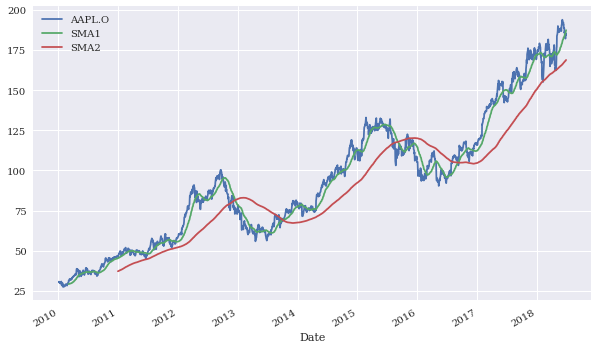

In [ ]:
SMA1 = 42
SMA2 = 252
data['SMA1'] = data[symbol].rolling(SMA1).mean()
data['SMA2'] = data[symbol].rolling(SMA2).mean()
data.plot(figsize=(10, 6))

Eliminamos las celdas vacias.
data.dropna(inplace=True)

Para incluir la decisión utilizamos la función de numpy where que es equivalente a un si en excel.


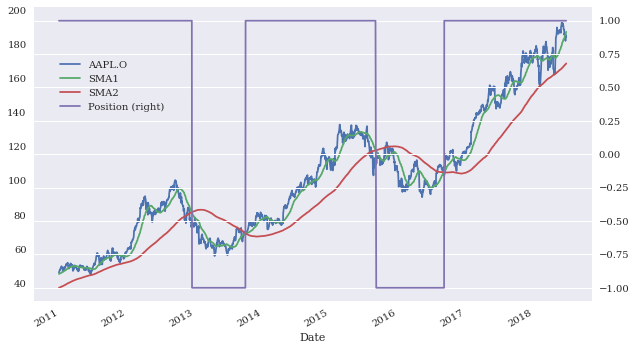

In [ ]:
data.dropna(inplace=True)
data['Position'] = np.where(data['SMA1'] > data['SMA2'], 1, -1)
ax = data.plot(secondary_y='Position',figsize=(10, 6))
ax.get_legend().set_bbox_to_anchor((0.25,0.85))



1.   Calculamos las rentabilidades
2.   Generamos una columna con los resultados de la estrategia.Es decir sumamos las rentabilidades cuando estamos en corto y las restamos cuando estamos en largo.
3.   Sumamos las rentabilidades de no hacer nada y las comparamos con la suma de las rentabilidades de seguir la estrategia de medias móviles. Trabajamos con rentabilidades en tiempo continuo $e^{\sum r_t}$
4.   Hemos estimado la desviación de típica de ambas estrategias.







In [ ]:
data['Returns'] = np.log(data[symbol] / data[symbol].shift(1))
data['Strategy'] = data['Position'].shift(1) * data['Returns']
np.exp(data[['Returns', 'Strategy']].sum())

Returns     4.017148
Strategy    5.811299
dtype: float64

In [ ]:
data[['Returns', 'Strategy']].var() * 252 ** 0.5

Returns     0.003955
Strategy    0.003950
dtype: float64

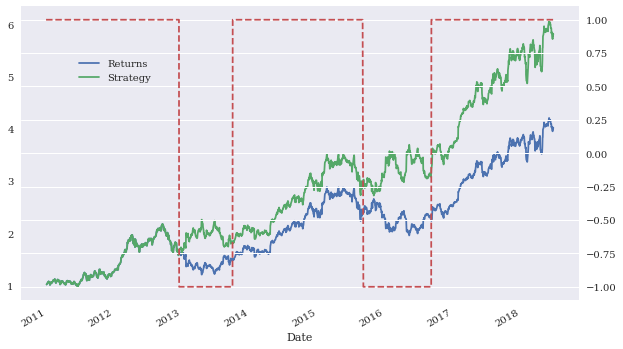

In [ ]:
ax = data[['Returns', 'Strategy']].cumsum().apply(np.exp).plot(figsize=(10, 6))
data['Position'].plot(ax=ax, secondary_y='Position', style='--')
ax.get_legend().set_bbox_to_anchor((0.25, 0.85))

Importamos el módulo itertools para poder utilizar la herramienta product. Ello premitirá realizar todas las combinaciones posibles de los distintos periodos de corto y largo plazo.

In [ ]:
from itertools import product

In [ ]:
sma1 = range(20, 61, 4)
sma2 = range(180, 281, 10)
results = pd.DataFrame()

In [ ]:
for SMA1, SMA2 in product(sma1, sma2):
    data = pd.DataFrame(raw[symbol])
    data.dropna(inplace=True)
    data['Returns'] = np.log(data[symbol] /data[symbol].shift(1))
    data['SMA1'] = data[symbol].rolling(SMA1).mean()
    data['SMA2'] = data[symbol].rolling(SMA2).mean()
    data.dropna(inplace=True)
    data['Position'] = np.where(data['SMA1'] > data['SMA2'],1, -1)
    data['Strategy'] = data['Position'].shift(1) * data['Returns']
    data.dropna(inplace=True)
    perf = np.exp(data[['Returns', 'Strategy']].sum())
    results = results.append(pd.DataFrame({'SMA1': SMA1, 'SMA2': SMA2,'MARKET': perf['Returns'],'STRATEGY': perf['Strategy']
                                           ,'OUT': perf['Strategy'] - perf['Returns']},index=[0]), ignore_index=True)


In [ ]:
results.sort_values('OUT', ascending=False).head(7)

,SMA1,SMA2,MARKET,STRATEGY,OUT
56,40,190,4.650342,7.175173,2.524831
39,32,240,4.045619,6.558690,2.513071
59,40,220,4.220272,6.544266,2.323994
46,36,200,4.074753,6.389627,2.314874
55,40,180,4.574979,6.857989,2.283010
70,44,220,4.220272,6.469843,2.249571
101,56,200,4.074753,6.319524,2.244772


#PASEO ALEATORIO

In [ ]:
symbol = '.SPX'
data = pd.DataFrame(raw[symbol])
lags = 5
cols = []

In [ ]:
for lag in range(1, lags + 1):
    col = 'lag_{}'.format(lag)
    data[col] = data[symbol].shift(lag)
    cols.append(col)

In [ ]:
data.head(7)

,.SPX,lag_1,lag_2,lag_3,lag_4,lag_5
Date,,,,,,
2010-01-01,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-04,1132.99,NaN,NaN,NaN,NaN,NaN
2010-01-05,1136.52,1132.99,NaN,NaN,NaN,NaN
2010-01-06,1137.14,1136.52,1132.99,NaN,NaN,NaN
2010-01-07,1141.69,1137.14,1136.52,1132.99,NaN,NaN
2010-01-08,1144.98,1141.69,1137.14,1136.52,1132.99,NaN
2010-01-11,1146.98,1144.98,1141.69,1137.14,1136.52,1132.99


In [ ]:
data.dropna(inplace=True)

Utilizamos linalg.lstsq herrmienta de numpy que permite realizar regresiones por MCO.


1.   Selecionamos las variables independientes data[cols]
2.   Indicamos la variable dependiente data[symbol]
3.   Indicamos que los coeficientes muy pequeños sean tratados como ceros rcond=-1
4.   La salida es una matriz tuple no modificable por ello le pedimos que sea modificable[0].





In [ ]:
reg = np.linalg.lstsq(data[cols], data[symbol], rcond=-1)[0]
reg.round(3)

array([0.966, 0.005, 0.025, 0.   , 0.003])

<BarContainer object of 5 artists>

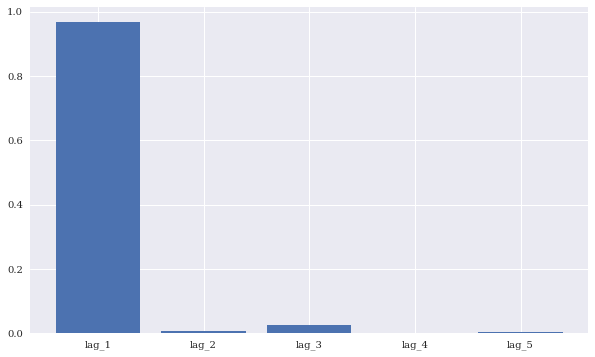

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(cols, reg)

Estimamos las predicciones realizadas por el modelo y las comparamos con los datos reales.

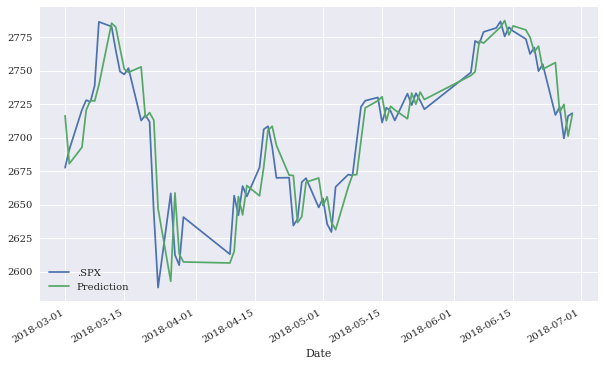

In [ ]:
data['Prediction'] = np.dot(data[cols], reg)
data[[symbol,'Prediction']].iloc[-75:].plot(figsize=(10, 6))

## Trading con divisas

In [ ]:
symbol = 'EUR='
data = pd.DataFrame(raw[symbol])
data['returns'] = np.log(data / data.shift(1))
data.dropna(inplace=True)
data['direction'] =np.sign(data['returns']).astype(int)
data.head(7)

,EUR=,returns,direction
Date,,,
2010-01-04,1.4411,0.006125,1
2010-01-05,1.4368,-0.002988,-1
2010-01-06,1.4412,0.003058,1
2010-01-07,1.4318,-0.006544,-1
2010-01-08,1.4412,0.006544,1
2010-01-11,1.4513,0.006984,1
2010-01-12,1.4494,-0.001310,-1


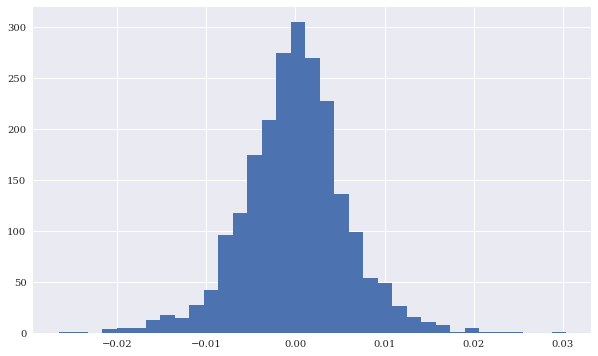

In [ ]:
data['returns'].hist(bins=35, figsize=(10, 6))

In [ ]:
lags = 2
lag=0
def create_lags(data):
    global cols
    cols = []
    for lag in range(1, lags + 1):
        col = 'lag_{}'.format(lag)
        data[col] = data['returns'].shift(lag)
        cols.append(col)

In [ ]:
create_lags(data)
data.head()

,EUR=,returns,direction,lag_1,lag_2
Date,,,,,
2010-01-04,1.4411,0.006125,1,NaN,NaN
2010-01-05,1.4368,-0.002988,-1,0.006125,NaN
2010-01-06,1.4412,0.003058,1,-0.002988,0.006125
2010-01-07,1.4318,-0.006544,-1,0.003058,-0.002988
2010-01-08,1.4412,0.006544,1,-0.006544,0.003058


In [ ]:
data.dropna(inplace=True)

Recurrimos a una biblioteca esencial de Machine Learning (sklearn),necesitamos la función para estimar regresiones lineales.

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
model = LinearRegression()
data['pos_ols_1'] = model.fit(data[cols], data['returns']).predict(data[cols])
data['pos_ols_2'] = model.fit(data[cols], data['direction']).predict(data[cols])

In [ ]:
data[['pos_ols_1', 'pos_ols_2']].head()

,pos_ols_1,pos_ols_2
Date,,
2010-01-06,-0.000002,-0.000663
2010-01-07,-0.000164,0.001545
2010-01-08,0.000030,0.032971
2010-01-11,-0.000245,-0.004227
2010-01-12,-0.000154,-0.061068


Proponemos una estrategia. Cuando el signo es positivo tomamos una posición larga y cuando es negativo una posición corta.

In [ ]:
data[['pos_ols_1', 'pos_ols_2']] = np.where(data[['pos_ols_1', 'pos_ols_2']] > 0, 1, -1)
data[['pos_ols_1', 'pos_ols_2']].head()


,pos_ols_1,pos_ols_2
Date,,
2010-01-06,-1,-1
2010-01-07,-1,1
2010-01-08,1,1
2010-01-11,-1,-1
2010-01-12,-1,-1


In [ ]:
data['pos_ols_1'].value_counts()

-1    1863
 1     350
Name: pos_ols_1, dtype: int64

In [ ]:
data['pos_ols_2'].value_counts()

 1    1310
-1     903
Name: pos_ols_2, dtype: int64

In [ ]:
(data['pos_ols_1'].diff() != 0).sum()

653

In [ ]:
(data['pos_ols_2'].diff() != 0).sum()

766

In [ ]:
data['strat_ols_1'] = data['pos_ols_1'] * data['returns']
data['strat_ols_2'] = data['pos_ols_2'] * data['returns']

In [ ]:
data[['returns', 'strat_ols_1', 'strat_ols_2']].sum().apply(np.exp)

returns        0.813126
strat_ols_1    0.987177
strat_ols_2    1.287336
dtype: float64

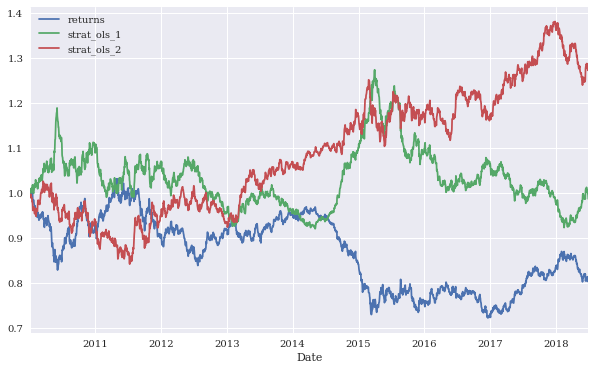

In [ ]:
data[['returns', 'strat_ols_1','strat_ols_2']].cumsum().apply(np.exp).plot(figsize=(10, 6))